In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

import ipyparallel as ipp

rc= ipp.Cluster(n=4,cluster_id='mycluster').start_and_connect_sync() # start 4 processes on the local computer

lview = rc.load_balanced_view() # default load-balanced view
buffer= len(rc.ids)*1           # We need buffer to feed the processes, large datasets might run out of memory
print("Number of engines:",rc.ids, "| Buffer ", buffer)

n= 50; m=100;            # Shape of the data input
frames= 100;               # Number of data inputs to generate
N_workers= 5;            # Numbers of instances to work on the analysis


with rc[:].sync_imports(): # Import modules on the engines
    import numpy
    from time import sleep
    
    
# Simple analysis =================================================================
def analyze(data):
    sums= numpy.zeros(data.shape[0]);
    for i in range(data.shape[0]):
        sum= 0;
        for j in range(data.shape[1]):
            sum= sum + data[i,j];
        sums[i]= sum;
    sleep(1);         # Let's slow it down artificially
    return sums;

#class for callbacks ===============================================================       
class Collect_data:
    def __init__(self):
        self.count= 0
        self.histograms= np.zeros(n)
    
    #the callback function
    def add(self, histograms):
        # we must use lock here because += is not atomic
        self.count+= 1
        self.histograms= np.add(self.histograms, histograms.result())

collect_data= Collect_data()

# ==================================================================================
# MAIN
# ==================================================================================
# Generate random data, analyze, and collect =======================================
frame= 0
while True:
    if frame >= frames:
        break
    
    if frame%10 == 0:
        np.save("analized",collect_data.histograms);
    
    while lview.queue_status()["unassigned"] > buffer:   # Wait for emty buffer 
        print(f'Frame {frame} | Buffer full {lview.queue_status()["unassigned"]}, waiting... \r',end='')
        sleep(1)
        
    frame+= 1
    task= lview.apply_async(analyze, np.random.rand(n,m))
    task.add_done_callback(collect_data.add)


lview.wait(); # Wait to finish

# Done
print(f'Frame {frame} | Buffer full {lview.queue_status()["unassigned"]}, waiting... \r')
print('Done.')
np.save("analized",collect_data.histograms);
rc.shutdown(hub=True)

Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Number of engines: [0, 1, 2, 3] | Buffer  4
importing numpy on engine(s)
importing sleep from time on engine(s)
Frame 100 | Buffer full 0, waiting... 
Done.


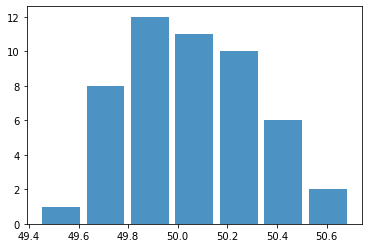

engine set stopped 1654768519: {'engines': {'3': {'exit_code': 0, 'pid': 10474, 'identifier': '3'}, '2': {'exit_code': 0, 'pid': 10471, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 10468, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 10466, 'identifier': '0'}}, 'exit_code': 0}
Controller stopped: {'exit_code': 0, 'pid': 10422, 'identifier': 'ipcontroller-mycluster-10393'}


In [2]:
histograms_from_file= np.load("analized.npy")
plt.hist(histograms_from_file/frames, bins='auto', alpha=0.8 ,rwidth=0.85);